<p style="background: orange;  color: blue; text-align: center;letter-spacing: 2px; line-height: 150%; font-weight:bold; font-size:xx-large;">The Partition Transform</p>
<p style="background: color: blue; text-align: center;">Peter Luschny, March 2016<br> updated August 2022</p>

<p>The notebook can be downloaded from
<a href = "https://github.com/PeterLuschny/PartitionTransform/blob/main/PartitionTransform.ipynb">GitHub</a>. The notebook requires a SageMath kernel and was tested with SageMath 9.6. If you do not have (the free and open) SageMath installed, we recommend using it in the cloud at <a href="https://cocalc.com/">CoCalc</a>.
The notebook was designed in connection with my blog at the 
<a href = "http://oeis.org/wiki/User:Peter_Luschny/P-Transform">OEIS-Wiki</a>.</p> 

In [1]:
%load_ext sage

import operator
from functools import cache
from typing import Callable
from itertools import accumulate
from sage.combinat.partition import Partition, Partitions
from sage.all import ZZ, QQ, factorial, binomial, product, matrix, srange, oeis
from sage.all import rising_factorial, falling_factorial, bell_number, var
from sage.all import stirling_number1, stirling_number2, bernoulli_polynomial
from sage.all import SR, PolynomialRing, expand, flatten
from sage.all import plot, show

<h3 style="color:#CD5C5C;background:white; line-height: 150%;border-top: thick solid #CD5C5C; float: left; width: 100%; margin-top: 1em;">
The Partition Transform<span style="font-size:small">
[see <a href="https://oeis.org/wiki/User:Peter_Luschny/P-Transform">OEIS-blog</a>]</span></h3>

We introduce a **sequence-to-triangle transformation** which we will call 
the partition transformation (or short P-transformation).
The name derives from the main loop in formula 1, which runs over all partitions of n. 

We say, $p$ is an integer partition of $n$ or 
$p \in P_{n}$ 
$\Longleftrightarrow$ 
* $p = (p_{1}, \ldots, p_{n}), \ p_{i}$ integer, 
* $\sum_{1\le i \le n} p_{i}  = n$ and 
* $p_{1} \ge p_{2}  \ge \ldots \ge p_{n} \ge 0.$ 

Given a sequence $a = a_1, a_2, a_3, \ldots$ let

$$ \mathcal{P}_{n}(a) = \sum_{p \in P_n} (-x)^{p_1} 
\binom{p_1}{p_2}\binom{p_2}{p_3} \ldots \binom{p_{n-1}}{p_{n}} 
a_1^{p_1} a_2^{p_2} \ldots a_n^{p_n}. $$

Note that both the enumeration of the terms of a partition and the given sequence start at index $1$. The partition can be seen extended by as much zeors after the last nonzero term to the right as might be convenient.

<h2 style='color:#5E7AFF;'>Formula <span style='color:orange'>1</span></h2>

The partition formula generates a triangle of polynomials, i.e. a sequence of polynomials $p_n(x)$ with $deg(p_n) = n$, which are by default evaluated at $x = 1$. Note that the polynomials are given in monomial form, i.e. as a list of monomials. Traditionally these monomials are called the 'partial polynomials' and the sum of the partial polynomials the 'complete polynomials'. However, we will not use this terminology.

In [2]:
def PartitionTransform(n: int, f: Callable, norm: Callable=None, x: int=1) -> list[int]:
    if n == 0:
        return [1]
    R = [0] * (n + 1)
    for q in Partitions(n):
        p = q + [0]
        R[q[0]] += (-x)^q[0] * product(binomial(p[j], p[j + 1]) * f(j + 1)^p[j] 
                               for j in range(len(q)))

    if norm == None: return R
    return [norm(n, k) * R[k] for k in range(n + 1)]

Note that the 'sequence' is given in the form of an integer-valued function, i.e. $a[n] = f(n)$. 

(Only for readers of the code: Internally different indexing must be balanced: partitions are indexed in Sage starting with 0, so we have to shift the index of the sequence by one place.)

We give some examples: 

In [3]:
f = lambda n: 1
for n in range(7):
    print(PartitionTransform(n, f, x=x))

[1]
[0, -x]
[0, -x, x^2]
[0, -x, 2*x^2, -x^3]
[0, -x, 3*x^2, -3*x^3, x^4]
[0, -x, 4*x^2, -6*x^3, 4*x^4, -x^5]
[0, -x, 5*x^2, -10*x^3, 10*x^4, -5*x^5, x^6]


In [4]:
f = lambda n: n
for n in range(7):
    print(PartitionTransform(n, f, x=x))

[1]
[0, -x]
[0, -2*x, x^2]
[0, -6*x, 4*x^2, -x^3]
[0, -24*x, 16*x^2, -6*x^3, x^4]
[0, -120*x, 72*x^2, -30*x^3, 8*x^4, -x^5]
[0, -720*x, 372*x^2, -152*x^3, 48*x^4, -10*x^5, x^6]


<h2 style='color:#5E7AFF;margin-bottom:16px'>Formula <span style='color:orange'>2</span></h2>

<p>Lah numbers of order 2, A268434.</p>

In [5]:
lah2 = lambda n: 1 if n == 1 else ((n - 1)^2 + 1) / (n * (4 * n - 2))
norm = lambda n, k: (-1)^k * factorial(2 * n) // factorial(2 * k)

for n in range(8):
    print(PartitionTransform(n, lah2, norm))

[1]
[0, 1]
[0, 2, 1]
[0, 10, 10, 1]
[0, 100, 140, 28, 1]
[0, 1700, 2900, 840, 60, 1]
[0, 44200, 85800, 31460, 3300, 110, 1]
[0, 1635400, 3476200, 1501500, 203060, 10010, 182, 1]


<h2 style='color:#5E7AFF;margin-bottom:16px'>Formula <span style='color:orange'>3</span></h2>
<p>Joffe's central differences of zero, A241171.</p>

In [6]:
eul = lambda n: 1 / ((2 * n - 1) * (2 * n))
nrm = lambda n, k: (-1)^k * factorial(2 * n)

for n in range(8):
    print(PartitionTransform(n, eul, nrm))

[1]
[0, 1]
[0, 1, 6]
[0, 1, 30, 90]
[0, 1, 126, 1260, 2520]
[0, 1, 510, 13230, 75600, 113400]
[0, 1, 2046, 126720, 1580040, 6237000, 7484400]
[0, 1, 8190, 1171170, 28828800, 227026800, 681080400, 681080400]


<h2 style='color:#5E7AFF;margin-bottom:16px'>Formula <span style='color:orange'>4</span></h2>
<p>Triangle of Ward numbers, A134991, better A269939.</p>

In [7]:
ward = lambda n: 1 / (n + 1)
norm = lambda n, k: (-1)^k * falling_factorial(n + k, n)

for n in range(8):
    print(PartitionTransform(n, ward, norm))

[1]
[0, 1]
[0, 1, 3]
[0, 1, 10, 15]
[0, 1, 25, 105, 105]
[0, 1, 56, 490, 1260, 945]
[0, 1, 119, 1918, 9450, 17325, 10395]
[0, 1, 246, 6825, 56980, 190575, 270270, 135135]


<h3 style="color:#CD5C5C;background:white; line-height: 150%;border-top: thick solid #CD5C5C; float: left; width: 100%; margin-top: 1em;">
Partition polynomials (P-polynomials)<span style="font-size:small">
[see <a href="https://oeis.org/wiki/User:Peter_Luschny/P-Transform#.E2.99.A6.C2.A0P-polynomials">OEIS-blog</a>]</span></h3>

<h2 style='color:#5E7AFF;margin-bottom:16px'>Formula <span style='color:orange'>5</span></h2>

This function will be our workhorse. It is a recursive implementation of the PartitionTransform, but it provides at the same time the inverse PartitionTransform and the reduced PartitionTransform, whose call is controlled by boolean flags. Below we will explain these variants one by one. In the OEIS the function is listed in A269941.

In [8]:
def PMatrix(dim: int, f: Callable, norm: Callable=None, 
            inverse: bool=False, reduced: bool=False) -> list:

    # compensate the different indexing with a shift in the argument.
    F = [f(i + 1) for i in range(dim + 1)]
    if not reduced:
        F = list(accumulate(F, operator.mul)) 

    C = [[0 for k in range(m + 1)] for m in range(dim)]
    C[0][0] = 1
    
    if inverse:
        for m in range(1, dim):
            C[m][m] = -C[m - 1][m - 1] / F[0]
            for k in range(m - 1, 0, -1):
                C[m][k] = (expand(-(C[m - 1][k - 1]
                           + sum(F[i] * C[m][k + i] 
                             for i in range(m - k + 1))
                     ) / F[0])
                )
    else:
        for m in range(1, dim):
            C[m][m] = -C[m - 1][m - 1] * F[0]
            for k in range(m - 1, 0, -1):
                C[m][k] = expand(-sum(F[i] * C[m - i - 1][k - 1] 
                          for i in range(m - k + 1)))

    if norm == None: return C
    for m in range(1, dim):
        for k in range(1, m + 1):
            C[m][k] = C[m][k] * norm(m, k)
    return C

<h2 style='color:#5E7AFF;margin-bottom:16px'>Formula <span style='color:orange'>6</span></h2>

The table below shows the partition matrix when the sequence of symbols $x_1, x_2, ...$ is fed into the transform. The entries in the lower traingular array might be called multivariate partial polynomials. Given an integer sequence $a_1, a_2, ...$ the resulting integer triangle is produced by substituting $x_n = a_n$ for all $n$.

<table style="width: 100%; text-align:center; background-color:#CDE1BA "> 
<tr style="background-color:#FFD700; color:blue">
<td>1</td>
<td>0</td>
<td>0</td>
<td>0</td>
<td>0</td>
<td>0</td>
</tr>
<tr style="background-color:#FFD700; color:blue">
<td>0</td>
<td>-x<sub>1</sub></td>
<td>0</td>
<td>0</td>
<td>0</td>
<td>0</td>
</tr>
<tr style="background-color:#FFD700; color:blue">
<td>0</td>
<td>-x<sub>1</sub>x<sub>2</sub></td>
<td>x<sub>1</sub><sup>2</sup></td>
<td>0</td>
<td>0</td>
<td>0</td>
</tr>
<tr style="background-color:#FFD700; color:blue">
<td>0</td>
<td>-x<sub>1</sub>x<sub>2</sub>x<sub>3</sub></td>
<td>2x<sub>1</sub><sup>2</sup>x<sub>2</sub></td>
<td>-x<sub>1</sub><sup>3</sup></td>
<td>0</td>
<td>0</td>
</tr>
<tr style="background-color:#FFD700; color:blue">
<td>0</td>
<td>-x<sub>1</sub>x<sub>2</sub>x<sub>3</sub>x<sub>4</sub></td>
<td>2x<sub>1</sub><sup>2</sup>x<sub>2</sub>x<sub>3</sub>+x<sub>1</sub><sup>2</sup>x<sub>2</sub><sup>2</sup></td>
<td>-3x<sub>1</sub><sup>3</sup>x<sub>2</sub></td>
<td>x<sub>1</sub><sup>4</sup></td>
<td>0</td>
</tr>
<tr style="background-color:#FFD700; color:blue">
<td>0</td>
<td>-x<sub>1</sub>x<sub>2</sub>x<sub>3</sub>x<sub>4</sub>x<sub>5</sub></td>
<td>2x<sub>1</sub><sup>2</sup>x<sub>2</sub>x<sub>3</sub>x<sub>4</sub>+2x<sub>1</sub> <sup>2</sup>x<sub>2</sub><sup>2</sup>x<sub>3</sub></td>
<td>-3x<sub>1</sub><sup>3</sup>x<sub>2</sub>x<sub>3</sub>
-3x<sub>1</sub><sup>3</sup>x<sub>2</sub><sup>2</sup></td>
<td>4x<sub>1</sub><sup>4</sup>x<sub>2</sub></td>
<td>-x<sub>1</sub><sup>5</sup></td>
</tr>
</table>


In [9]:
f = lambda n: var('x' + str(n))
PMatrix(5, f)

[[1],
 [0, -x1],
 [0, -x1*x2, x1^2],
 [0, -x1*x2*x3, 2*x1^2*x2, -x1^3],
 [0, -x1*x2*x3*x4, x1^2*x2^2 + 2*x1^2*x2*x3, -3*x1^3*x2, x1^4]]

latex(PMatrix(5, f))

$$\left[1\right] $$ 
$$\left[0, -x_{1}\right] $$ 
$$\left[0, -x_{1} x_{2}, x_{1}^{2}\right] $$ 
$$\left[0, -x_{1} x_{2} x_{3}, 2 \, x_{1}^{2} x_{2}, -x_{1}^{3}\right] $$
$$\left[0, -x_{1} x_{2} x_{3} x_{4}, x_{1}^{2} x_{2}^{2} + 2 \, x_{1}^{2} x_{2} x_{3}, -3 \, x_{1}^{3} x_{2}, x_{1}^{4}\right]$$

<h2 style='color:#5E7AFF;margin-bottom:16px'>Formula <span style='color:orange'>7</span></h2>
Number of lists of k unlabeled permutations whose total length is n, A090238.

In [10]:
PMatrix(8, lambda n: n, lambda n, k: (-1)^k)

[[1],
 [0, 1],
 [0, 2, 1],
 [0, 6, 4, 1],
 [0, 24, 16, 6, 1],
 [0, 120, 72, 30, 8, 1],
 [0, 720, 372, 152, 48, 10, 1],
 [0, 5040, 2208, 828, 272, 70, 12, 1]]

<h3 style="color:#CD5C5C;background:white; line-height: 150%;border-top: thick solid #CD5C5C; float: left; width: 100%; margin-top: 1em;">
The inverse of the partition transform<span style="font-size:small">
[see <a href="https://oeis.org/wiki/User:Peter_Luschny/P-Transform#.E2.99.A6.C2.A0The_inverse_of_the_P-transform">OEIS-blog</a>]</span></h3>

The inverse of the partition transform is defined as the inverse of the lower triangular matrix of the partial partition polynomials.

<h2 style='color:#5E7AFF;margin-bottom:16px'>Formula <span style='color:orange'>8</span></h2>

In [11]:
f = lambda n: var("x" + str(n))
P = PMatrix(5, f, inverse=True)

for p in P:
    print(p)

[1]
[0, -1/x1]
[0, -x2/x1^2, x1^(-2)]
[0, -2*x2^2/x1^3 + x2*x3/x1^3, 2*x2/x1^3, -1/x1^3]
[0, -5*x2^3/x1^4 + 5*x2^2*x3/x1^4 - x2*x3*x4/x1^4, 5*x2^2/x1^4 - 2*x2*x3/x1^4, -3*x2/x1^4, x1^(-4)]


<h2 style='color:#5E7AFF;margin-bottom:16px'>Formula <span style='color:orange'>9</span></h2>

Clearly $x_1$ must not be zero. And most of the time we can require $x_1 = 1$.
For this case let's simplify the polynomials:

In [12]:
[[p.substitute(x1=1) for p in L] for L in P] 

[[1],
 [0, -1],
 [0, -x2, 1],
 [0, -2*x2^2 + x2*x3, 2*x2, -1],
 [0, -5*x2^3 + 5*x2^2*x3 - x2*x3*x4, 5*x2^2 - 2*x2*x3, -3*x2, 1]]

<h2 style='color:#5E7AFF;margin-bottom:16px'>Formula <span style='color:orange'>10</span></h2>

In [13]:
PMatrix(8, lambda n: n, inverse=True)

[[1],
 [0, -1],
 [0, -2, 1],
 [0, -2, 4, -1],
 [0, -4, 8, -6, 1],
 [0, 4, 16, -18, 8, -1],
 [0, -48, 12, -44, 32, -10, 1],
 [0, 336, 96, -72, 96, -50, 12, -1]]

Note that a row reversed version with different signs is A059370.

In [14]:
PMatrix(8, lambda n: n, lambda n, k: (-1)^k)

[[1],
 [0, 1],
 [0, 2, 1],
 [0, 6, 4, 1],
 [0, 24, 16, 6, 1],
 [0, 120, 72, 30, 8, 1],
 [0, 720, 372, 152, 48, 10, 1],
 [0, 5040, 2208, 828, 272, 70, 12, 1]]

This is triangle A090238.

<h2 style='color:#5E7AFF;margin-bottom:16px'>Formula <span style='color:orange'>11</span></h2>

The triangle generated by the constant sequence 1.

In [15]:
PMatrix(8, lambda n: 1, inverse=True)

[[1],
 [0, -1],
 [0, -1, 1],
 [0, -1, 2, -1],
 [0, -1, 3, -3, 1],
 [0, -1, 4, -6, 4, -1],
 [0, -1, 5, -10, 10, -5, 1],
 [0, -1, 6, -15, 20, -15, 6, -1]]

Apart from signs: Compositions of n with k parts, T(n, k) = binomial(n-1, k-1), A097805.

In [16]:
PMatrix(8, lambda n: 1)

[[1],
 [0, -1],
 [0, -1, 1],
 [0, -1, 2, -1],
 [0, -1, 3, -3, 1],
 [0, -1, 4, -6, 4, -1],
 [0, -1, 5, -10, 10, -5, 1],
 [0, -1, 6, -15, 20, -15, 6, -1]]

In [17]:
def S(n, k): 
    return (-1)^k * (factorial(k) *
        sum(stirling_number1(n, j) * stirling_number2(j, k)
        for j in range(k, n + 1))) // factorial(n)

for n in range(8):
    print([S(n, k) for k in range(n + 1)])

[1]
[0, -1]
[0, -1, 1]
[0, -1, 2, -1]
[0, -1, 3, -3, 1]
[0, -1, 4, -6, 4, -1]
[0, -1, 5, -10, 10, -5, 1]
[0, -1, 6, -15, 20, -15, 6, -1]


The last three observations can be summarized as:

$$ \mathcal{P}(\textbf{1}) = (-1)^k\frac{k!}{n!} \sum_{j=k}^n 
{n \brack j} \left \{ j \atop k \right \} = \mathcal{P^{-1}}(\textbf{1}) $$ 

where $\textbf{1} = 1, 1, 1, \ldots \,$. See A271703 for the unsigned version.

<h3 style="color:#CD5C5C;background:white; line-height: 150%;border-top: thick solid #CD5C5C; float: left; width: 100%; margin-top: 1em;">
Evaluating the partition transform<span style="font-size:small"></h3>

Some utility functions ...

<h2 style='color:#5E7AFF;margin-bottom:16px'>Formula <span style='color:orange'>12</span></h2>

Partition transform evaluated at $ x = val$.

In [18]:
def PEvalAt(n, f, val = None, norm = None):
    P = PMatrix(n, f, norm)
    if val == None: val = var('x')
    p = [sum([val^k*P[j][k] for k in (0..j)]) for j in range(n)]
    return p

# for linguistic reason only, equivalent to PEvalAt(n, f, norm)
PAsPoly = lambda n, f, norm=None: PEvalAt(n, f, norm = norm)

In [19]:
PAsPoly(5, lambda n: n)

[1, -x, x^2 - 2*x, -x^3 + 4*x^2 - 6*x, x^4 - 6*x^3 + 16*x^2 - 24*x]

In [20]:
PEvalAt(9, lambda n: n, val = 1)

[1, -1, -1, -3, -13, -71, -461, -3447, -29093]

This is A167894, or, apart from signs, the number of irreducible permutations A003319.

In [21]:
PEvalAt(9, lambda n: n, val = -1)

[1, 1, 3, 11, 47, 231, 1303, 8431, 62391]

This is A051296, the number of compositions of $n$ where there are $k!$ sorts of part $k$.

In [22]:
def PAnalyser(Len, f, norm = None):
    print("As polynomials:")
    P = PAsPoly(Len - 2, f, norm)
    for p in P: print(p)
    
    print("As triangle:")
    P = PMatrix(Len - 2, f, norm)
    for p in P: print(p)
    
    print("x=1:   ", PEvalAt(Len, f,   1, norm))
    print("x=-1:  ", PEvalAt(Len, f,  -1, norm))
    if norm == None: return
    print("x=1/2: ", PEvalAt(Len, f, 1/2, lambda n,k: 2^n * norm(n, k)))
    print("x=-1/2:", PEvalAt(Len, f,-1/2, lambda n,k: 2^n * norm(n, k)))

In [23]:
f = lambda n: 1

PAnalyser(8, f)

As polynomials:
1
-x
x^2 - x
-x^3 + 2*x^2 - x
x^4 - 3*x^3 + 3*x^2 - x
-x^5 + 4*x^4 - 6*x^3 + 4*x^2 - x
As triangle:
[1]
[0, -1]
[0, -1, 1]
[0, -1, 2, -1]
[0, -1, 3, -3, 1]
[0, -1, 4, -6, 4, -1]
x=1:    [1, -1, 0, 0, 0, 0, 0, 0]
x=-1:   [1, 1, 2, 4, 8, 16, 32, 64]


<h3 style="color:#CD5C5C;background:white; line-height: 150%;border-top: thick solid #CD5C5C; float: left; width: 100%; margin-top: 1em;">
Representations of the Euler and Bernoulli numbers<span style="font-size:small">
[see <a href="https://oeis.org/wiki/User:Peter_Luschny/P-Transform#.E2.99.A6.C2.A0Representations_of_the_Euler_and_Bernoulli_numbers">OEIS-blog</a>]</span></h3>

<h2 style='color:#5E7AFF;margin-bottom:16px'>Formula <span style='color:orange'>13</span></h2>


$$ E_{2n} = (2n)! \sum_{p \in P_n} (-1)^{p_1} 
\binom{p_1}{p_2}\binom{p_2}{p_3} \ldots \binom{p_{n-1}}{p_{n}} 
\left(\frac{1}{1 \cdot 2}\right)^{p_1} \left(\frac{1}{3 \cdot 4}\right)^{p_2}  \ldots
\left(\frac{1}{(2n-1)2n}\right)^{p_n} $$

In [24]:
eul = lambda n: 1 / ((2 * n - 1) * (2 * n))
nrm = lambda n, k: factorial(2 * n)

PAnalyser(8, eul, nrm)  # Euler(2n)

As polynomials:
1
-x
6*x^2 - x
-90*x^3 + 30*x^2 - x
2520*x^4 - 1260*x^3 + 126*x^2 - x
-113400*x^5 + 75600*x^4 - 13230*x^3 + 510*x^2 - x
As triangle:
[1]
[0, -1]
[0, -1, 6]
[0, -1, 30, -90]
[0, -1, 126, -1260, 2520]
[0, -1, 510, -13230, 75600, -113400]
x=1:    [1, -1, 5, -61, 1385, -50521, 2702765, -199360981]
x=-1:   [1, 1, 7, 121, 3907, 202741, 15430207, 1619195761]
x=1/2:  [1, -1, 4, -34, 496, -11056, 349504, -14873104]
x=-1/2: [1, 1, 8, 154, 5552, 321616, 27325088, 3200979664]


The polynomials are case m = 2 of those defined in A278073. See also A241171, Joffe's central differences of zero, and its refinement A327022, the ordered set partitions of the set $\{1, 2, ..., 2n\}$ with all block sizes divisible by $2$. See also A028296, A094088, A002105, and A356900.

<h2 style='color:#5E7AFF;margin-bottom:16px'>Formula <span style='color:orange'>14</span></h2>

$$ B_{2n} = \frac{(2n)!}{(2-2^{2n})} \sum_{p \in P_n} (-1)^{p_1} 
\binom{p_1}{p_2}\binom{p_2}{p_3} \ldots \binom{p_{n-1}}{p_{n}} 
\left(\frac{1}{2 \cdot 3}\right)^{p_1} \left(\frac{1}{4 \cdot 5}\right)^{p_2}  
\ldots \left(\frac{1}{2n  (2n+1)}\right)^{p_n} $$

In [25]:
bern = lambda n: 1 / ((2 * n) * (2 * n + 1))
norm = lambda n, k: factorial(2 * n) / (2 - 2^(2 * n))

PAnalyser(7, bern, norm)  # Bernoulli(2n)

As polynomials:
1
1/6*x
-1/21*x^2 + 1/70*x
5/93*x^3 - 1/31*x^2 + 1/434*x
-140/1143*x^4 + 14/127*x^3 - 41/1905*x^2 + 1/2286*x
As triangle:
[1]
[0, 1/6]
[0, 1/70, -1/21]
[0, 1/434, -1/31, 5/93]
[0, 1/2286, -41/1905, 14/127, -140/1143]
x=1:    [1, 1/6, -1/30, 1/42, -1/30, 5/66, -691/2730]
x=-1:   [1, -1/6, -13/210, -115/1302, -2911/11430, -13509/11242, -46675903/5588310]
x=1/2:  [1, 1/6, -2/105, -1/651, 88/5715, -24/803, 24352/2794155]
x=-1/2: [1, -1/6, -8/105, -83/651, -824/1905, -40504/16863, -2386864/121485]


See A356652/A356653.

In [26]:
quad = lambda n: 1 / n^2
norm = lambda n, k: factorial(n)^2

PAnalyser(8, quad, norm)  

As polynomials:
1
-x
4*x^2 - x
-36*x^3 + 18*x^2 - x
576*x^4 - 432*x^3 + 68*x^2 - x
-14400*x^5 + 14400*x^4 - 3900*x^3 + 250*x^2 - x
As triangle:
[1]
[0, -1]
[0, -1, 4]
[0, -1, 18, -36]
[0, -1, 68, -432, 576]
[0, -1, 250, -3900, 14400, -14400]
x=1:    [1, -1, 3, -19, 211, -3651, 90921, -3081513]
x=-1:   [1, 1, 5, 55, 1077, 32951, 1451723, 87054773]
x=1/2:  [1, -1, 2, -4, -24, 784, -14080, 142624]
x=-1/2: [1, 1, 6, 76, 1720, 60816, 3096384, 214579296]


See A192722, A000275, A102221, A340886.

<h3 style="color:#CD5C5C;background:white; line-height: 150%;border-top: thick solid #CD5C5C; float: left; width: 100%; margin-top: 1em;">
Recurrence for the case x = 1<span style="font-size:small">
[see <a href="https://oeis.org/wiki/User:Peter_Luschny/P-Transform#.E2.99.A6.C2.A0Recurrence_for_the_case_x_.3D_1">OEIS-blog</a>]</span></h3>

<h2 style='color:#5E7AFF;margin-bottom:16px'>Formula <span style='color:orange'>15</span></h2>

In [27]:
def Pcoeffsum(len, f, norm=None):
    R, C = [1], [1] + [0] * (len - 1)

    for n in range(1, len):
        for k in range(n, 0, -1):
            C[k] = C[k - 1] * f(k)
        C[0] = -sum(C[k] for k in range(1, n + 1))
        if norm == None:
            R.append(C[0])
        else:
            R.append(C[0] * norm(n))
    return R

In [28]:
print(Pcoeffsum(9, lambda n: n))
print(PEvalAt(9, lambda n: n, 1)) 

[1, -1, -1, -3, -13, -71, -461, -3447, -29093]
[1, -1, -1, -3, -13, -71, -461, -3447, -29093]


Trivially the sum of coefficients is the same as the value of the polynomial at $x=1$. It is one of the most important charateristics of the sequence of polynomials in our setup. A famous example are the Bernoulli numbers (if properly defined). See also the Sage implementation of A001896 (cosecant numbers).

<h2 style='color:#5E7AFF;margin-bottom:16px'>Formula <span style='color:orange'>16</span></h2>

In [29]:
def bernoulli_list(len):
    f, R, C = 1, [1], [1] + [0] * (len - 1)
    for n in range(1, len):
        f *= n
        for k in range(n, 0, -1):
            C[k] = -C[k - 1] / (k + 1)
        C[0] = -sum(C[k] for k in range(1, n + 1))
        R.append(C[0] * f)
    return R


print(bernoulli_list(13))
print([bernoulli_polynomial(1, n) for n in range(13)])

[1, 1/2, 1/6, 0, -1/30, 0, 1/42, 0, -1/30, 0, 5/66, 0, -691/2730]
[1, 1/2, 1/6, 0, -1/30, 0, 1/42, 0, -1/30, 0, 5/66, 0, -691/2730]


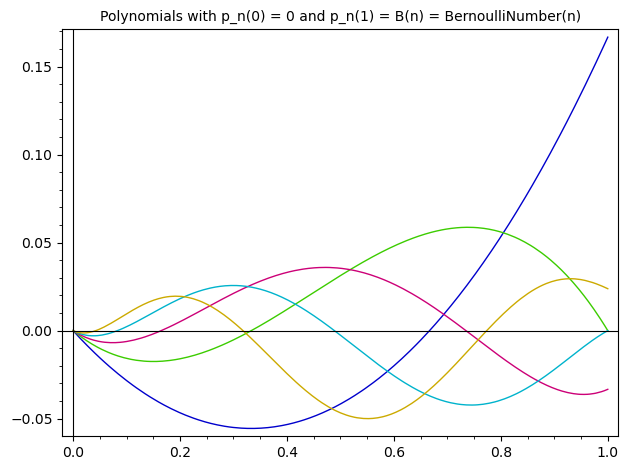

In [30]:
P = plot([1/2*x^2 - 1/3*x, -3/4*x^3 + x^2 - 1/4*x, 3/2*x^4 - 3*x^3 + 5/3*x^2 
-1/5*x, -15/4*x^5 + 10*x^4 - 35/4*x^3 + 8/3*x^2 - 1/6*x,  45/4*x^6 - 75/2*x^5
+ 45*x^4 -137/6*x^3 + 17/4*x^2 - 1/7*x], (x,0,1))
show(P, frame=True, title=
'Polynomials with p_n(0) = 0 and p_n(1) = B(n) = BernoulliNumber(n)')

<h3 style="color:#CD5C5C;background:white; line-height: 150%;border-top: thick solid #CD5C5C; float: left; width: 100%; margin-top: 1em;">
The P-inverse of the sequence</h3>

The sequence P-inverse of the sequence $a_1, a_2, a_3,... $ are the terms which appear in column 1 of the partition matrix of $a$. In other words:

$$ \mathcal{p^{-1}}(a) = [x^1] \mathcal{P^{-1}}(a) $$ 

Or, if full detail, the first few terms of the the sequence P-inverse are:
 
$$ \mathcal{p^{-1}}(a) =  -\frac{1}{a_1}, -\frac{a_2}{a_1^2}, 
 -\frac{2a_2^2 + a_2a_3}{a_1^3} , - \frac{5a_2^3  + 5a_2^2a_3  - a_2a_3a_4 }{a_1^4}, ...$$

<h2 style='color:#5E7AFF;margin-bottom:16px'>Formula <span style='color:orange'>17</span></h2>

Some examples:

In [31]:
def PInverseSequence(n, f, norm=None):
    M = PMatrix(n, f, norm, inverse=True)
    return [M[j][1] for j in range(1, n)]

print(PInverseSequence(9, lambda n: 1))
print(PInverseSequence(9, lambda n: n))  # A059372 Revert transform of factorials
print(PInverseSequence(9, lambda n: n^2))
print(PInverseSequence(8, lambda n: factorial(n)))
print(PInverseSequence(8, lambda n: binomial(2*n, n) / (n+1)))

[-1, -1, -1, -1, -1, -1, -1, -1]
[-1, -2, -2, -4, 4, -48, 336, -2928]
[-1, -4, 4, -176, 5200, -222720, 12509184, -889421568]
[-1, -2, 4, -208, 31456, -24408768, 125014717056]
[-1, -2, 2, -80, 4516, -699944, 320903552]


In [32]:
print(PInverseSequence(9, lambda n: -1 / n))

S = PInverseSequence(9, lambda n: (n + 1) / n)
print(S)
print([-2^(2 * n + 1) * r for n, r in enumerate(S)])

[1, 1/2, 1/3, 1/4, 1/5, 1/6, 1/7, 1/8]
[-1/2, -3/8, -5/16, -35/128, -63/256, -231/1024, -429/2048, -6435/32768]
[1, 3, 10, 35, 126, 462, 1716, 6435]


Number of monotone maps from {0, ..., n} to {0, ..., n}, A001700.

<h3 style="color:#CD5C5C;background:white; line-height: 150%;border-top: thick solid #CD5C5C; float: left; width: 100%; margin-top: 1em;">
Benchmark</h3>

In [33]:
import time

def timeit(statement):
    durations = []
    for i in range(3):
        start = time.time()
        eval(statement)
        end = time.time()
        t = end - start
        durations.append(t)
    return min(durations)

def benchmark(stmt):
    t = timeit(stmt)
    r = round(t * 1000, 3)
    print(f"{stmt} best time: {r} ms")

In [34]:
for n in range(10, 40, 10):
    benchmark(f"PartitionTransform({n}, lambda n: n)")

PartitionTransform(10, lambda n: n) best time: 13.283 ms
PartitionTransform(20, lambda n: n) best time: 292.584 ms
PartitionTransform(30, lambda n: n) best time: 3387.469 ms


In [35]:
for n in range(10, 40, 10):
    benchmark(f"PMatrix({n}, lambda n: n)")

PMatrix(10, lambda n: n) best time: 0.71 ms
PMatrix(20, lambda n: n) best time: 5.664 ms
PMatrix(30, lambda n: n) best time: 11.667 ms


<h3 style="color:#CD5C5C;background:white; line-height: 150%;border-top: thick solid #CD5C5C; float: left; width: 100%; margin-top: 1em;">
The coefficients of the multivariate P-polynomials <span style="font-size:small">
[see <a href="https://oeis.org/wiki/User:Peter_Luschny/P-Transform#.E2.99.A6.C2.A0The_coefficients_of_the_multivariate_P-polynomials">OEIS-blog</a>]</span></h3>

In [36]:
def PartitionCoefficients(dim, norm=None, inverse=False):
    def coeff(P, n, k):
        if k == 0: return [k^n]
        return SR(P[n][k]).fraction(ZZ).numerator().coefficients() 

    f = lambda n: var("x" + str(n))
    P = PMatrix(dim, f, norm, inverse)

    return [[coeff(P, n, k) for k in range(0, n + 1)] for n in range(dim)]

In [37]:
PartitionCoefficients(7)

[[[1]],
 [[0], [-1]],
 [[0], [-1], [1]],
 [[0], [-1], [2], [-1]],
 [[0], [-1], [1, 2], [-3], [1]],
 [[0], [-1], [2, 2], [-3, -3], [4], [-1]],
 [[0], [-1], [1, 2, 2], [-1, -6, -3], [6, 4], [-5], [1]]]

| n\k | 0 | 1  | 2    | 3    | 4    |5     | 6    |
| :---: | :---:  | :---:| :---:| :---:| :---:|:---: |:---:|
| (0) | 1 | -  | -    | -    | -    |-     | -    | 
| (1) | 0 | -1 | -    | -    | -    |-     | -    | 
| (2) | 0 | -1 | 1 | -    | -    |-     | -    | 
| (3) | 0 | -1 | 2 | -1 | -    |-     | -   |
| (4) | 0 | -1 | [1, 2] | -3 | 1 |-     | -    | 
| (5) | 0 | -1 | [2, 2] | [-3, -3] | 4| -1 |- |
| (6) | 0 | -1 | [1, 2, 2] | [-1, -6, -3] | [6, 4] | -5 | 1 |

<a href="https://oeis.org/A269941">A269941</a> the coefficients of the partial P-polynomials.

In [38]:
@cache
def PartCoeffs(n: int, k: int):  # A356656
    Z = var(["z_" + str(i) for i in range(1, n - k + 2)])
    R = PolynomialRing(ZZ, Z, n - k + 1, order='lex')
    if k == 0: return R(k^n)
    return R(-sum(PartCoeffs(n - j, k - 1) * Z[j - 1] 
            for j in range(1, n - k + 2)).expand())


def PolyRow(n): 
    return [PartCoeffs(n, k) for k in range(n + 1)]


def CoeffRow(n): 
    return flatten([[0] if (c := p.coefficients()) == [] 
                        else c for p in PolyRow(n)])


def ReducedRow(n): 
    return flatten([0 if (c := p.coefficients()) == [] 
                      else sum(c) for p in PolyRow(n)])

In [39]:
for n in range(5): 
    print(PolyRow(n))

for n in range(5): 
    print(CoeffRow(n))

for n in range(5):
    r = ReducedRow(n)
    print(r, "sum =", sum(r))

[1]
[0, -z_1]
[0, -z_2, z_1^2]
[0, -z_3, 2*z_1*z_2, -z_1^3]
[0, -z_4, 2*z_1*z_3 + z_2^2, -3*z_1^2*z_2, z_1^4]
[1]
[0, -1]
[0, -1, 1]
[0, -1, 2, -1]
[0, -1, 2, 1, -3, 1]
[1] sum = 1
[0, -1] sum = -1
[0, -1, 1] sum = 0
[0, -1, 2, -1] sum = 0
[0, -1, 3, -3, 1] sum = 0


In [40]:
# For comparison only, the Bell transform:

@cache
def BellPartCoeffs(n: int, k: int):  # A356656
    Z = var(["z_" + str(i) for i in range(n - k + 1)])
    R = PolynomialRing(ZZ, Z, n - k + 1, order='lex')
    if k == 0: return R(k^n)
    return R(sum(binomial(n - 1, j - 1) * PartCoeffs(n - j, k - 1) * Z[j - 1]
            for j in range(n - k + 2)).expand())

A111786, the complete symmetric function in n variables in terms of the elementary symmetric functions. 

Or the unsigned version A048996: The refinement of Pascal's triangle A007318 using the Abramowitz-Stegun order.

In [41]:
PartitionCoefficients(6, inverse = True)

[[[1]],
 [[0], [-1]],
 [[0], [-1], [1]],
 [[0], [-2, 1], [2], [-1]],
 [[0], [-5, 5, -1], [5, -2], [-3], [1]],
 [[0], [-14, 21, -3, -6, 1], [14, -12, 2], [-9, 3], [4], [-1]]]

| n\k | 0 | 1  | 2    | 3    | 4    |5     | 
| :---: | :---:  | :---:| :---:| :---:| :---:|:---: |
| (0) | 1 | -  | -    | -    | -    |- | 
| (1) | 0 | -1 | -    | -    | -    |- | 
| (2) | 0 | -1 | 1    | -    | -    |- |  
| (3) | 0 |-2, 1| 2   | -1   | -    |- | 
| (4) | 0 |-5, 5, -1 | 5, -2| -3| 1| - | 
| (5) | 0 |-14, 21, -3, -6, 1| 14, -12, 2| -9, 3| 4| -1 |


<a href="https://oeis.org/A269942">A269942</a> the coefficients of the inverse partial P-polynomials.

<h3 style="color:#CD5C5C;background:white; line-height: 150%;border-top: thick solid #CD5C5C; float: left; width: 100%; margin-top: 1em;">
The reduced P-transformation <span style="font-size:small">
[see <a href="https://oeis.org/wiki/User:Peter_Luschny/P-Transform#.E2.99.A6.C2.A0The_reduced_P-transformation">OEIS-blog</a>]</span>
</h3>

| n\k | 0 | 1 | 2 | 3 | 4 |5 | 6 |
| :---: | :---: | :---:| :---:| :---:| :---:|:---: |:---:|
| (0) | 1 | - | - | - | - |- | - |
| (1) | 0 | $-x_1$ | - | - | - |- | - |
| (2) | 0 | $-x_2$ | $x_1^2$ | - | - |- | - |
| (3) | 0 | $-x_3$ | $2x_1x_2$| $-x_1^3$ | - |- | - |
| (4) | 0 | $-x_4$ | $2x_1x_3 + x_2^2$ | $-3x_1^2x_2$ | $x_1^4$ |- | - |
| (5) | 0 | $-x_5$ | $2x_1x_4 + 2x_2x_3$ | $-3x_1^2x_3 - 3x_1x_2^2$ | $4x_1^3x_2$| $x_1^5$ | |
| (6) | 0 | $-x_6$ | $x_3^2 + 2x_2x_4 + 2x_1x_5$ | $-x_2^3 -6x_1x_2x_3 - 3x_1^2x_4 $ | $6x_1^2x_2^2 + 4x_1^3x_3$ | $-5x_1^4x_2$ | $x_1^6$ |

<h3 style="color:#CD5C5C;background:white; line-height: 150%;border-top: thick solid #CD5C5C; float: left; width: 100%; margin-top: 1em;">
Stirling and Lah numbers of higher order<span style="font-size:small">
[see <a href="https://oeis.org/wiki/User:Peter_Luschny/P-Transform#.E2.99.A6.C2.A0_Stirling_and_Lah_numbers_of_higher_order">OEIS-blog</a>]</span></h3>

<h2 style='color:#5E7AFF;margin-bottom:16px'>Formula <span style='color:orange'>18</span></h2>

Stirling set numbers of order 2, Stirling cycle numbers of order 2, and Lah numbers of order 2 and their inverse. Stirling cycle numbers of order 2 are also known as central factorial numbers t(2n, 2k) and Stirling set numbers of order 2 are also known as central factorial numbers T(2n, 2k).

See A269945, A269944, A268434.

In [42]:
stirset2   = lambda n: 1 if n == 1 else               1 / (n * (4 * n - 2)) 
stircycle2 = lambda n: 1 if n == 1 else       (n - 1)^2 / (n * (4 * n - 2)) 
lah2       = lambda n: 1 if n == 1 else (1 + (n - 1)^2) / (n * (4 * n - 2)) 
norm       = lambda n,k: (-1)^k * factorial(2 * n) // factorial(2 * k)

In [43]:
M = PMatrix(7, stirset2, norm)
for m in M: print(m)


M = PMatrix(7, stirset2, norm, inverse=True)
for m in M: print(m)

[1]
[0, 1]
[0, 1, 1]
[0, 1, 5, 1]
[0, 1, 21, 14, 1]
[0, 1, 85, 147, 30, 1]
[0, 1, 341, 1408, 627, 55, 1]
[1]
[0, 1]
[0, 1, 1]
[0, 4, 5, 1]
[0, 36, 49, 14, 1]
[0, 576, 820, 273, 30, 1]
[0, 14400, 21076, 7645, 1023, 55, 1]


In compact format all three cases for all orders:

In [44]:
@cache
def StirlingLah(typ, m, n, k):
    if n == k: return 1 
    if k < 0 or k > n: return 0 
    if   typ == "S1": r = (n - 1)**m
    elif typ == "S2": r = k**m
    elif typ == "La": r = (n - 1)**m + k**m
    return ( StirlingLah(typ, m, n - 1, k - 1)
           + StirlingLah(typ, m, n - 1, k) * r)

oeis = iter(["A007318", "A132393", "A269944", "A007318", 
"A048993", "A269945", "A038207", "A271703", "A268434"])

def show_all():
    for typ in ["S1", "S2", "La"]:
        for order in range(3):
            print(f"\n{typ} / {order} : {next(oeis)}")
            for n in range(7): 
                print([StirlingLah(typ, order, n, k) for k in range(n + 1)])
# show_all()

<h2 style='color:#5E7AFF;margin-bottom:16px'>Formula <span style='color:orange'>19</span></h2>

In [45]:
M = PMatrix(7, stircycle2, norm)
for m in M: print(m)


M = PMatrix(7, stircycle2, norm, inverse=True)
for m in M: print(m)

[1]
[0, 1]
[0, 1, 1]
[0, 4, 5, 1]
[0, 36, 49, 14, 1]
[0, 576, 820, 273, 30, 1]
[0, 14400, 21076, 7645, 1023, 55, 1]
[1]
[0, 1]
[0, 1, 1]
[0, 1, 5, 1]
[0, 1, 21, 14, 1]
[0, 1, 85, 147, 30, 1]
[0, 1, 341, 1408, 627, 55, 1]


<h2 style='color:#5E7AFF;margin-bottom:16px'>Formula <span style='color:orange'>20</span></h2>

In [46]:
M = PMatrix(7, lah2, norm)
for m in M: print(m)


M = PMatrix(7, lah2, norm, inverse=True)
for m in M: print(m)

[1]
[0, 1]
[0, 2, 1]
[0, 10, 10, 1]
[0, 100, 140, 28, 1]
[0, 1700, 2900, 840, 60, 1]
[0, 44200, 85800, 31460, 3300, 110, 1]
[1]
[0, 1]
[0, 2, 1]
[0, 10, 10, 1]
[0, 100, 140, 28, 1]
[0, 1700, 2900, 840, 60, 1]
[0, 44200, 85800, 31460, 3300, 110, 1]


<h2 style='color:#5E7AFF;margin-bottom:16px'>Formula <span style='color:orange'>21</span></h2>

Stirling set numbers of order 3, Stirling cycle numbers of order 3, and Lah numbers of order 3 and their inverse.

See A269948, A269947, A269946.

In [47]:
stirset3 = lambda n, k: k^3
stircycle3 = lambda n, k: (n - 1)^3
lah3 = lambda n, k: stircycle3(n, k) + stirset3(n, k)

In [48]:
def T(n, k, w):
    if n == k: return 1
    if k < 0 or k > n: return 0
    return T(n - 1, k - 1, w) + w(n, k) * T(n - 1, k, w)

for n in range(6):
    print([T(n, k, stirset3) for k in range(n + 1)])

for n in range(6):
    print([T(n, k, stircycle3) for k in range(n + 1)])
    
for n in range(6):
    print([T(n, k, lah3) for k in range(n + 1)])

[1]
[0, 1]
[0, 1, 1]
[0, 1, 9, 1]
[0, 1, 73, 36, 1]
[0, 1, 585, 1045, 100, 1]
[1]
[0, 1]
[0, 1, 1]
[0, 8, 9, 1]
[0, 216, 251, 36, 1]
[0, 13824, 16280, 2555, 100, 1]
[1]
[0, 1]
[0, 2, 1]
[0, 18, 18, 1]
[0, 504, 648, 72, 1]
[0, 32760, 47160, 7200, 200, 1]


<h3 style="color:#CD5C5C;background:white; line-height: 150%;border-top: thick solid #CD5C5C; float: left; width: 100%; margin-top: 1em;">
The StirlingStar numbers<span style="font-size:small">
[see <a href="https://oeis.org/wiki/User:Peter_Luschny/P-Transform#.E2.99.A6.C2.A0_Some_additional_Stirling_number_identities">OEIS-blog</a>]</span></h3>

<h2 style='color:#5E7AFF;margin-bottom:16px'>Formula <span style='color:orange'>22</span></h2>

$$ \left\{ {n\atop k} \right\}^{\star} = (-1)^k (2n)! \, \mathcal{P}^k_n \left(1,\frac12,\frac13,\frac14,\ldots \right) $$

$$ \left[ {n\atop k} \right]^{\star} = (-1)^k (2n)! \, \mathcal{P}^k_n \left(1,\frac12,\frac23,\frac34,\ldots \right) $$

$$ \genfrac\{\}{0pt}{}{n}{k}^{\star}
= \frac{(2n)!}{(n+k)^{\underline{n}}} \sum_{m=0}^{k} (-1)^{m+k} \binom{n+k}{n+m}\genfrac\{\}{0pt}{}{n+m}{m} $$

$$ \genfrac{ [ }{ ] }{0pt}{}{n}{k}^{\star} 
= \frac{(2n)!}{(n+k)^{\underline{n}}} \sum_{m=0}^{k} (-1)^{m+k} \binom{n+k}{n+m}\genfrac{[ }{ ] }{0pt}{}{n+m}{m} $$

We call these numbers StirlingSetStar and StirlingCycleStar. These names were invented here only to be able to reference them easily, there may be better names. The numerical values of the StirlingStar numbers can be found in A268437 and A268438. Considering the simplicity of their partition representation, it seems that they have received too little attention so far.

In [49]:
StirlingSetStar   = lambda n: 1 / (n + 1)
StirlingCycleStar = lambda n: n / (n + 1)

norm = lambda n, k: (-1)^k * factorial(2 * n)

In [50]:
PMatrix(7, StirlingSetStar, norm)

[[1],
 [0, 1],
 [0, 4, 6],
 [0, 30, 120, 90],
 [0, 336, 2800, 5040, 2520],
 [0, 5040, 80640, 264600, 302400, 113400],
 [0, 95040, 2827440, 15190560, 29937600, 24948000, 7484400]]

In [51]:
PMatrix(7, StirlingCycleStar, norm)

[[1],
 [0, 1],
 [0, 8, 6],
 [0, 180, 240, 90],
 [0, 8064, 14560, 10080, 2520],
 [0, 604800, 1330560, 1285200, 604800, 113400],
 [0, 68428800, 173638080, 209341440, 139708800, 49896000, 7484400]]

<h2 style='color:#5E7AFF;margin-bottom:16px'>Formula <span style='color:orange'>23</span></h2>

$$
(n-k+1)^{\overline{n-k}} \, \genfrac\{\}{0pt}{}{n}{k} 
= \binom{n}{k} \sum_{i=0}^{k} \binom{k}{i} \genfrac\{\}{0pt}{}{n-k}{i}^{\star} 
= \binom{-k}{-n} \sum_{i=0}^{n-k} \binom{-n}{i} \genfrac{[ }{ ] }{0pt}{}{n-k}{i}^{\star} $$

$$ (n-k+1)^{\overline{n-k}} \, \genfrac{ [ }{ ] }{0pt}{}{n}{k} 
= \binom{n}{k} \sum_{i=0}^{k} \binom{k}{i} \genfrac{ [ }{ ] }{0pt}{}{n-k}{i}^{\star}   
= \binom{-k}{-n} \sum_{i=0}^{n-k} \binom{-n}{i} \genfrac\{\}{0pt}{}{n-k}{i}^{\star} $$

In [52]:
T = lambda n, k: sum(
    (-1)^(m + k) * binomial(n + k, n + m) * stirling_number2(n + m, m)
    for m in range(k + 1))

N = lambda n, k: factorial(2 * n) // falling_factorial(n + k, n)

for n in range(7):
    print([T(n, k) * N(n, k) for k in range(n + 1)])

[1]
[0, 1]
[0, 4, 6]
[0, 30, 120, 90]
[0, 336, 2800, 5040, 2520]
[0, 5040, 80640, 264600, 302400, 113400]
[0, 95040, 2827440, 15190560, 29937600, 24948000, 7484400]


<h2 style='color:#5E7AFF;margin-bottom:16px'>Formula <span style='color:orange'>24</span></h2>

In [53]:
T = lambda n, k: sum(
    (-1)^(m + k) * binomial(n + k, n + m) * stirling_number1(n + m, m)
    for m in range(k + 1))

N = lambda n, k: factorial(2 * n) // falling_factorial(n + k, n)

for n in range(7):
    print([T(n, k) * N(n, k) for k in range(n + 1)])

[1]
[0, 1]
[0, 8, 6]
[0, 180, 240, 90]
[0, 8064, 14560, 10080, 2520]
[0, 604800, 1330560, 1285200, 604800, 113400]
[0, 68428800, 173638080, 209341440, 139708800, 49896000, 7484400]


<h3 style="color:#CD5C5C;background:white; line-height: 150%;border-top: thick solid #CD5C5C; float: left; width: 100%; margin-top: 1em;">
Some P-polynomials evaluated at x=1 or x=-1<span style="font-size:small">
[see <a href="https://oeis.org/wiki/User:Peter_Luschny/P-Transform#.E2.99.A6.C2.A0Some_P-polynomials_evaluated_at_x.3D1_or_x.3D-1">OEIS-blog</a>]</span></h3>


<table style="width: 100%; text-align:center; background-color:#CDE1BA ">  <tr>
<td>A000007</td>
<td>A000670</td>
<td>A001896</td>
<td>A003319</td>
<td>A006153</td>
<td>A006232</td></tr><tr>
<td>A006252</td>
<td>A006568</td>
<td>A006569</td>
<td>A007840</td>
<td>A027641</td>
<td>A027642</td></tr><tr>
<td>A036280</td>
<td>A036281</td>
<td>A036968</td>
<td>A051296</td>
<td>A075178</td>
<td>A077607</td></tr><tr>
<td>A089148</td>
<td>A101686</td>
<td>A113871</td>
<td>A118196</td>
<td>A135920</td>
<td>A154288</td></tr><tr>
<td>A154289</td>
<td>A167894</td>
<td>A198631</td>
<td>A226158</td>
<td>A248964</td>
<td>A249024</td></tr></table>